## **TripTact : An Intelligent Travel Planner Ai Agent**

In [ ]:
from google.colab import userdata
flight_key = userdata.get('FLIGHT_API_KEY')
gemini_api_key = userdata.get('GEMINI_API_KEY')


In [ ]:
%%capture --no-stderr
%pip install --quiet -U langchain_core langgraph langchain-google-genai langchain

In [ ]:
from langchain_google_genai import ChatGoogleGenerativeAI
llm = ChatGoogleGenerativeAI(model = 'gemini-1.5-flash' , api_key=gemini_api_key , temprature = 0.2)

In [ ]:
from langchain.prompts import PromptTemplate

prompt_converter_template = PromptTemplate(
    input_variables=["input"],
    template='''
    extract the departure and destination from the following text , and if you don't find any just return None:{input}
'''
)



In [ ]:
from typing_extensions import TypedDict
from pydantic import BaseModel ,Field
import re
import requests
from typing import List

class Flight_det(TypedDict):
    airline: List[str]
    flight_date: List[str]
    departure_airport: List[str]
    departure_time: List[str]
    arrival_airport: List[str]
    arrival_time: List[str]
    flight_number: List[str]

class state(TypedDict):
  prompt : str
  departure:str
  destination:str
  Interests : List[str]
  Flight_details:List[dict]
  interests:List[str]
  Plan:str




class Flight(BaseModel):
  departure:str = Field(description="departure location")
  destination:str = Field(description="destination location")


def prompt_converter(state:state):
  prompt = state['prompt']

  prompt = prompt_converter_template.format(input=prompt)
  structured_llm = llm.with_structured_output(Flight , include_raw=False)
  response = structured_llm.invoke(prompt)

  state['departure'] = response.departure
  state['destination'] = response.destination
  return state

def Data_Reviewer(state:state):
  destination = state['destination']
  departure = state['departure']
  prompt = state['prompt']

  if destination == 'None' or departure == 'None':
    user_input = input('You have not provided the departure or destiations clearly , specify the departure and destination cit or country specifically to get the better plan')
    state['prompt'] += user_input

    return state

  else :
    return state

def decide_Route(state:state):
  destination = state['destination']
  departure = state['departure']

  if destination == 'None' or departure == 'None':
    return "prompt_converter"
  else :
    return "Flight_Data"

class IataCodes(BaseModel):
  departure:str = Field(description="Iata code of thr airport of the departure location")
  destination:str = Field(description="Iata code of thr airport of the destination location")
def Flight_Data(state:state):

  structured_llm = llm.with_structured_output(IataCodes , include_raw=False)
  Flight_prompt = PromptTemplate(
    input_variables=["departure","destination"],
    template='''
    these are the places or cities , if it is a city or a town , then check the nearest airport andreturn their iata codes for both
    {departure} and {destination}
'''
  )
  structured_llm = llm.with_structured_output(IataCodes , include_raw=False)
  prompt = Flight_prompt.format(departure=state['departure'],destination=state['destination'])
  response = structured_llm.invoke(prompt)

  departure = response.departure
  destination = response.destination
  url = f'''https://api.aviationstack.com/v1/flights?access_key={flight_key}&dep_iata={departure}&arr_iata={destination}&limit=3'''



  Dataset = requests.get(url)
  Data = Dataset.json()

  if 'data' in Data and Data['data']:
    state = {}
    state['Flight_details'] = []  # Initialize as a list to store multiple flight details
    flight_data = Data['data']  # Assuming Data contains your flights

    for flight in flight_data:
        flight_details = {
            "airline": flight['airline']['name'],
            "flight_date": flight['flight_date'],
            "departure_airport": flight['departure']['airport'],
            "departure_time": flight['departure']['scheduled'],
            "arrival_airport": flight['arrival']['airport'],
            "arrival_time": flight['arrival']['scheduled'],
            "flight_number": flight['flight']['number']
        }
        state['Flight_details'].append(flight_details)  # Append each flight's details

    return state  # Returns the complete state after all flights have been added

  else:
    print('Sorry! We could not find any flight data due to some issues')


def Planner(state:state):
  destination : state['destination']
  interests : state['interests']
  prompt_template = PromptTemplate(
    input_variables=["interests" , "destination"],
    template='''
    Create a three day plan as i am visiting the : {destination} and my interests are :{interests} , Suggest me places and schedule my day make a timetable , from morning to evening
'''
  )
  prompt = prompt_template.format(interests=state['interests'],destination=state['destination'])
  response = llm.invoke(prompt)
  state['Plan'] = response
  return state






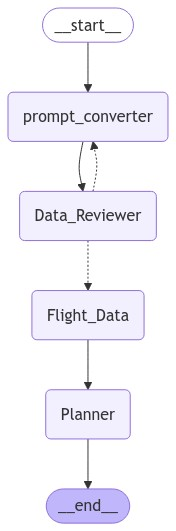

In [ ]:
from IPython.display import Image, display
from langgraph.graph import START, END, StateGraph
from langgraph.checkpoint.memory import MemorySaver
builder = StateGraph(state)
builder.add_node('prompt_converter', prompt_converter)
builder.add_node('Data_Reviewer', Data_Reviewer)
builder.add_node('Flight_Data', Flight_Data)
builder.add_node('Planner', Planner)
builder.add_edge(START, 'prompt_converter')
builder.add_edge('prompt_converter', 'Data_Reviewer')
builder.add_conditional_edges('Data_Reviewer' , decide_Route , ['prompt_converter' , 'Flight_Data'])
builder.add_edge('Flight_Data', 'Planner')
builder.add_edge('Planner',END)
graph = builder.compile()
display(Image(graph.get_graph(xray=5).draw_mermaid_png()))


In [34]:
ui = graph.invoke({"prompt":"Plan a travel trip to makkah for umrah from islamabad " , "interests":["mosques" , "food" , "relegion"]})

{'name': 'Flight', 'parameters': {'type_': 6, 'properties': {'destination': {'type_': 1, 'description': 'destination location', 'format_': '', 'nullable': False, 'enum': [], 'max_items': '0', 'min_items': '0', 'properties': {}, 'required': []}, 'departure': {'type_': 1, 'description': 'departure location', 'format_': '', 'nullable': False, 'enum': [], 'max_items': '0', 'min_items': '0', 'properties': {}, 'required': []}}, 'required': ['departure', 'destination'], 'format_': '', 'description': '', 'nullable': False, 'enum': [], 'max_items': '0', 'min_items': '0'}, 'description': ''}
{'name': 'IataCodes', 'parameters': {'type_': 6, 'properties': {'departure': {'type_': 1, 'description': 'Iata code of thr airport of the departure location', 'format_': '', 'nullable': False, 'enum': [], 'max_items': '0', 'min_items': '0', 'properties': {}, 'required': []}, 'destination': {'type_': 1, 'description': 'Iata code of thr airport of the destination location', 'format_': '', 'nullable': False, 'e

In [35]:
import textwrap
from IPython.display import display
from IPython.display import Markdown

def toMarkDown(text:str)->Markdown:
  text.replace('•' , '  *')
  return Markdown(textwrap.indent(text , ' >' , predicate=lambda _:True))

In [33]:
def display_trip_details(state):
    # Displaying the trip prompt
    print(f"Trip Plan: {state['prompt']}")
    print(f"Departure: {state['departure']}")
    print(f"Destination: {state['destination']}")
    print("\nFlight Details:")

    # Loop through each flight in the 'Flight_details' list
    for index, flight in enumerate(state['Flight_details'], start=1):
        print(f"\nFlight {index}:")
        print(f"  Airline: {flight['airline']}")
        print(f"  Flight Date: {flight['flight_date']}")
        print(f"  Departure Airport: {flight['departure_airport']}")
        print(f"  Departure Time: {flight['departure_time']}")
        print(f"  Arrival Airport: {flight['arrival_airport']}")
        print(f"  Arrival Time: {flight['arrival_time']}")
        print(f"  Flight Number: {flight['flight_number']}")

    # Displaying the user's interests
    print("\nInterests:")
    for interest in state['interests']:
        print(f"  - {interest}")

    # Displaying the generated trip plan content
    print("\nGenerated Trip Plan:")
    display(toMarkDown(state['Plan'].content))
     # Print the content of the AI-generated itinerary

# Call the function with your state dictionary
display_trip_details(ui)

Trip Plan: Plan a travel trip to makkah for umrah from islamabad 
Departure: islamabad
Destination: makkah

Flight Details:

Flight 1:
  Airline: Alitalia
  Flight Date: 2024-10-28
  Departure Airport: Islamabad International
  Departure Time: 2024-10-28T02:00:00+00:00
  Arrival Airport: King Abdulaziz International
  Arrival Time: 2024-10-28T05:45:00+00:00
  Flight Number: 5219

Flight 2:
  Airline: Serene Air
  Flight Date: 2024-10-28
  Departure Airport: Islamabad International
  Departure Time: 2024-10-28T07:05:00+00:00
  Arrival Airport: King Abdulaziz International
  Arrival Time: 2024-10-28T10:40:00+00:00
  Flight Number: 801

Flight 3:
  Airline: Alitalia
  Flight Date: 2024-10-28
  Departure Airport: Islamabad International
  Departure Time: 2024-10-28T10:55:00+00:00
  Arrival Airport: King Abdulaziz International
  Arrival Time: 2024-10-28T14:40:00+00:00
  Flight Number: 5433

Interests:
  - mosques
  - food
  - relegion

Generated Trip Plan:


 >## Makkah 3-Day Itinerary for Mosques, Food, and Religion:
 >
 >**Day 1: The Grand Mosque & Spiritual Journey**
 >
 >* **Morning (7:00 AM - 12:00 PM):**
 >    * Begin your day with a visit to the **Masjid al-Haram**, the holiest mosque in Islam. 
 >    * Perform Umrah (if you are a Muslim), or simply marvel at the grandeur of the mosque and its Kaaba, the direction Muslims face during prayer.
 >    * Explore the different levels of the mosque, including the surrounding courtyards and prayer areas.
 >    * Take time to reflect and pray in this sacred space.
 >* **Lunch (12:00 PM - 1:00 PM):**
 >    * Enjoy a traditional Saudi lunch at one of the many restaurants near the mosque. Try dishes like Mandi, Kabsa, or Madfoon. 
 >* **Afternoon (1:00 PM - 5:00 PM):**
 >    * Visit the **Masjid al-Quba**, the first mosque built by Prophet Muhammad (PBUH).
 >    * Reflect on the history and significance of this mosque.
 >    * Take a stroll through the nearby markets and experience the local atmosphere.
 >* **Evening (5:00 PM - 8:00 PM):**
 >    * Attend **Maghrib prayer** at the Masjid al-Haram.
 >    * Enjoy a delicious dinner at one of the many restaurants in the area.
 >    * Spend the evening reflecting on your spiritual journey and experiencing the unique ambiance of Makkah.
 >
 >**Day 2: Historical Sites & Cultural Exploration**
 >
 >* **Morning (7:00 AM - 12:00 PM):**
 >    * Explore the **Jannat al-Mu'alla cemetery**, the resting place of many prominent figures from Islamic history, including the Prophet's (PBUH) wives. 
 >    * Visit the **Masjid Aisha**, located near the cemetery, a mosque with a rich historical significance.
 >    * Learn about the history and significance of these locations from local guides or online resources.
 >* **Lunch (12:00 PM - 1:00 PM):**
 >    * Enjoy a lunch break at a local restaurant, trying authentic Saudi dishes.
 >* **Afternoon (1:00 PM - 5:00 PM):**
 >    * Visit the **Abraham's Well**, a sacred site believed to be where Prophet Abraham (PBUH) found water in Makkah.
 >    * Learn about the Abrahamic traditions and the significance of this site.
 >    * Explore the **Abrahamic Family House**, a multi-faith center promoting dialogue and understanding.
 >* **Evening (5:00 PM - 8:00 PM):**
 >    * Attend **Isha prayer** at the Masjid al-Haram.
 >    * Enjoy a traditional Saudi dinner and browse the local markets for souvenirs.
 >
 >**Day 3: Reflecting & Departing**
 >
 >* **Morning (7:00 AM - 12:00 PM):**
 >    * Spend the morning reflecting on your experiences and the lessons learned during your trip.
 >    * Visit the **Masjid al-Haram** one last time to pray and say goodbye.
 >    * Consider attending a **Khutbah** (sermon) at the mosque to gain further insight into Islamic teachings.
 >* **Lunch (12:00 PM - 1:00 PM):**
 >    * Enjoy a final lunch at a local restaurant, savoring the flavors of Makkah.
 >* **Afternoon (1:00 PM - 5:00 PM):**
 >    * Explore the **Makkah Museum**, learning about the city's history and culture.
 >    * Visit the **Makkah Clock Tower**, offering panoramic views of the city.
 >* **Evening (5:00 PM - 8:00 PM):**
 >    * Depart from Makkah, carrying with you the memories and spiritual enrichment of your journey.
 >
 >**Important Notes:**
 >
 >* This itinerary is flexible and can be adjusted based on your personal interests and time constraints.
 >* Remember to dress modestly and respectfully when visiting mosques and other sacred sites.
 >* Be mindful of prayer times and adjust your schedule accordingly.
 >* Take advantage of the numerous tour guides and resources available to enhance your understanding of Makkah.
 >* Enjoy the delicious and diverse food scene in Makkah, trying local delicacies and traditional dishes.
 >
 >**Bonus Tip:**
 >
 >* Consider taking a guided tour of the Masjid al-Haram to learn about its history and architecture in detail.
 >
 >This itinerary provides a framework for a meaningful and enriching journey to Makkah, allowing you to explore the city's mosques, food, and religious significance while connecting with your faith and experiencing the unique culture of Saudi Arabia.